In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score, accuracy_score, confusion_matrix, mean_squared_error, mean_absolute_error
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
import datetime
import warnings
warnings.filterwarnings('ignore')


In [8]:
# Set the style for better visualizations
plt.style.use('seaborn-v0_8')  # Using updated seaborn style name
sns.set_theme(style="whitegrid")  # Set seaborn theme
plt.rcParams['figure.figsize'] = [10, 6]  # Set default figure size
plt.rcParams['axes.grid'] = True  # Enable grid
sns.set_palette("husl")  # Set color palette

In [7]:
#read csv file
df = pd.read_csv('Global_Pollution_Analysis.csv')

In [9]:
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 13 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Country                                 200 non-null    object 
 1   Year                                    200 non-null    int64  
 2   Air_Pollution_Index                     200 non-null    float64
 3   Water_Pollution_Index                   200 non-null    float64
 4   Soil_Pollution_Index                    200 non-null    float64
 5   Industrial_Waste (in tons)              200 non-null    float64
 6   Energy_Recovered (in GWh)               200 non-null    float64
 7   CO2_Emissions (in MT)                   200 non-null    float64
 8   Renewable_Energy (%)                    200 non-null    float64
 9   Plastic_Waste_Produced (in tons)        200 non-null    float64
 10  Energy_Consumption_Per_Capita (in MWh)  200 non-null    float6

In [10]:
df.describe()


,Year,Air_Pollution_Index,Water_Pollution_Index,Soil_Pollution_Index,Industrial_Waste (in tons),Energy_Recovered (in GWh),CO2_Emissions (in MT),Renewable_Energy (%),Plastic_Waste_Produced (in tons),Energy_Consumption_Per_Capita (in MWh),Population (in millions),GDP_Per_Capita (in USD)
count,200.000000,200.00000,200.000000,200.000000,200.00000,200.000000,200.000000,200.000000,200.000000,200.00000,200.000000,200.000000
mean,2009.335000,180.62695,115.068100,76.488550,52891.68150,260.448700,24.878100,27.799700,24492.893550,9.43575,104.271300,35307.602400
std,5.765325,67.07331,47.580911,39.692727,27224.49169,147.141923,14.470892,12.361879,14421.356002,5.57567,56.906574,19481.714455
min,2000.000000,50.30000,31.130000,11.150000,1019.37000,11.730000,1.920000,5.040000,542.950000,0.53000,2.320000,1298.700000
25%,2004.000000,134.97250,74.550000,40.895000,31201.97250,118.355000,11.220000,17.700000,12843.882500,4.58250,60.960000,19525.020000
50%,2010.000000,183.38500,112.305000,78.600000,55299.15000,273.140000,25.355000,29.170000,24121.540000,9.22500,104.965000,35043.325000
75%,2014.000000,237.42500,157.477500,109.212500,74805.82500,384.957500,38.550000,37.072500,36516.232500,13.99750,150.930000,51629.547500
max,2019.000000,297.95000,199.320000,149.230000,99739.36000,499.980000,49.690000,49.560000,49852.280000,19.98000,198.820000,69143.140000


In [11]:
df.isnull().sum()


Country                                   0
Year                                      0
Air_Pollution_Index                       0
Water_Pollution_Index                     0
Soil_Pollution_Index                      0
Industrial_Waste (in tons)                0
Energy_Recovered (in GWh)                 0
CO2_Emissions (in MT)                     0
Renewable_Energy (%)                      0
Plastic_Waste_Produced (in tons)          0
Energy_Consumption_Per_Capita (in MWh)    0
Population (in millions)                  0
GDP_Per_Capita (in USD)                   0
dtype: int64

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 13 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Country                                 200 non-null    object 
 1   Year                                    200 non-null    int64  
 2   Air_Pollution_Index                     200 non-null    float64
 3   Water_Pollution_Index                   200 non-null    float64
 4   Soil_Pollution_Index                    200 non-null    float64
 5   Industrial_Waste (in tons)              200 non-null    float64
 6   Energy_Recovered (in GWh)               200 non-null    float64
 7   CO2_Emissions (in MT)                   200 non-null    float64
 8   Renewable_Energy (%)                    200 non-null    float64
 9   Plastic_Waste_Produced (in tons)        200 non-null    float64
 10  Energy_Consumption_Per_Capita (in MWh)  200 non-null    float6

In [16]:
print(df.columns)

Index(['Country', 'Year', 'Air_Pollution_Index', 'Water_Pollution_Index',
       'Soil_Pollution_Index', 'Industrial_Waste (in tons)',
       'Energy_Recovered (in GWh)', 'CO2_Emissions (in MT)',
       'Renewable_Energy (%)', 'Plastic_Waste_Produced (in tons)',
       'Energy_Consumption_Per_Capita (in MWh)', 'Population (in millions)',
       'GDP_Per_Capita (in USD)'],
      dtype='object')


In [17]:
# 1. Handle Missing Values
# Check percentage of missing values in each column
missing_percentages = (df.isnull().sum() / len(df)) * 100
print("Missing Values Percentage:")
print(missing_percentages[missing_percentages > 0])

# Fill numeric columns with median
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
for col in numeric_columns:
    if df[col].isnull().any():
        df[col].fillna(df[col].median(), inplace=True)

# Fill categorical columns with mode
categorical_columns = df.select_dtypes(include=['object']).columns
for col in categorical_columns:
    if df[col].isnull().any():
        df[col].fillna(df[col].mode()[0], inplace=True)

# Verify no missing values remain
print("\nRemaining missing values after imputation:")
print(df.isnull().sum()[df.isnull().sum() > 0])

Missing Values Percentage:
Series([], dtype: float64)

Remaining missing values after imputation:
Series([], dtype: int64)


In [19]:
# 2. Data Transformation

# Create a copy of the dataframe to avoid modifying the original
df_transformed = df.copy()

# Initialize the StandardScaler
scaler = StandardScaler()

# Get numeric columns for scaling (excluding Year if it exists)
numeric_cols = df_transformed.select_dtypes(include=['float64', 'int64']).columns
numeric_cols = [col for col in numeric_cols if col != 'Year']  # Exclude Year if present

# Scale numeric columns
if len(numeric_cols) > 0:
    df_transformed[numeric_cols] = scaler.fit_transform(df_transformed[numeric_cols])

# Initialize OneHotEncoder for categorical variables
categorical_cols = df_transformed.select_dtypes(include=['object']).columns
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Perform one-hot encoding for categorical columns
if len(categorical_cols) > 0:
    # Get encoded feature names
    encoded_features = encoder.fit_transform(df_transformed[categorical_cols])
    encoded_feature_names = []
    for i, col in enumerate(categorical_cols):
        encoded_feature_names.extend([f"{col}_{val}" for val in encoder.categories_[i]])
    
    # Create DataFrame with encoded features
    encoded_df = pd.DataFrame(encoded_features, columns=encoded_feature_names, index=df_transformed.index)
    
    # Drop original categorical columns and join encoded ones
    df_transformed = df_transformed.drop(columns=categorical_cols)
    df_transformed = pd.concat([df_transformed, encoded_df], axis=1)

# Display info about transformed dataset
print("\nTransformed Dataset Info:")
print(df_transformed.info())

# Display first few rows of transformed data
print("\nFirst few rows of transformed data:")
print(df_transformed.head())


Transformed Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Columns: 187 entries, Year to Country_Zimbabwe
dtypes: float64(186), int64(1)
memory usage: 292.3 KB
None

First few rows of transformed data:
   Year  Air_Pollution_Index  ...  Country_Zambia  Country_Zimbabwe
0  2005             1.376167  ...             0.0               0.0
1  2001            -1.403578  ...             0.0               0.0
2  2016            -1.330788  ...             0.0               0.0
3  2018             1.494394  ...             0.0               0.0
4  2008            -0.021926  ...             0.0               0.0

[5 rows x 187 columns]


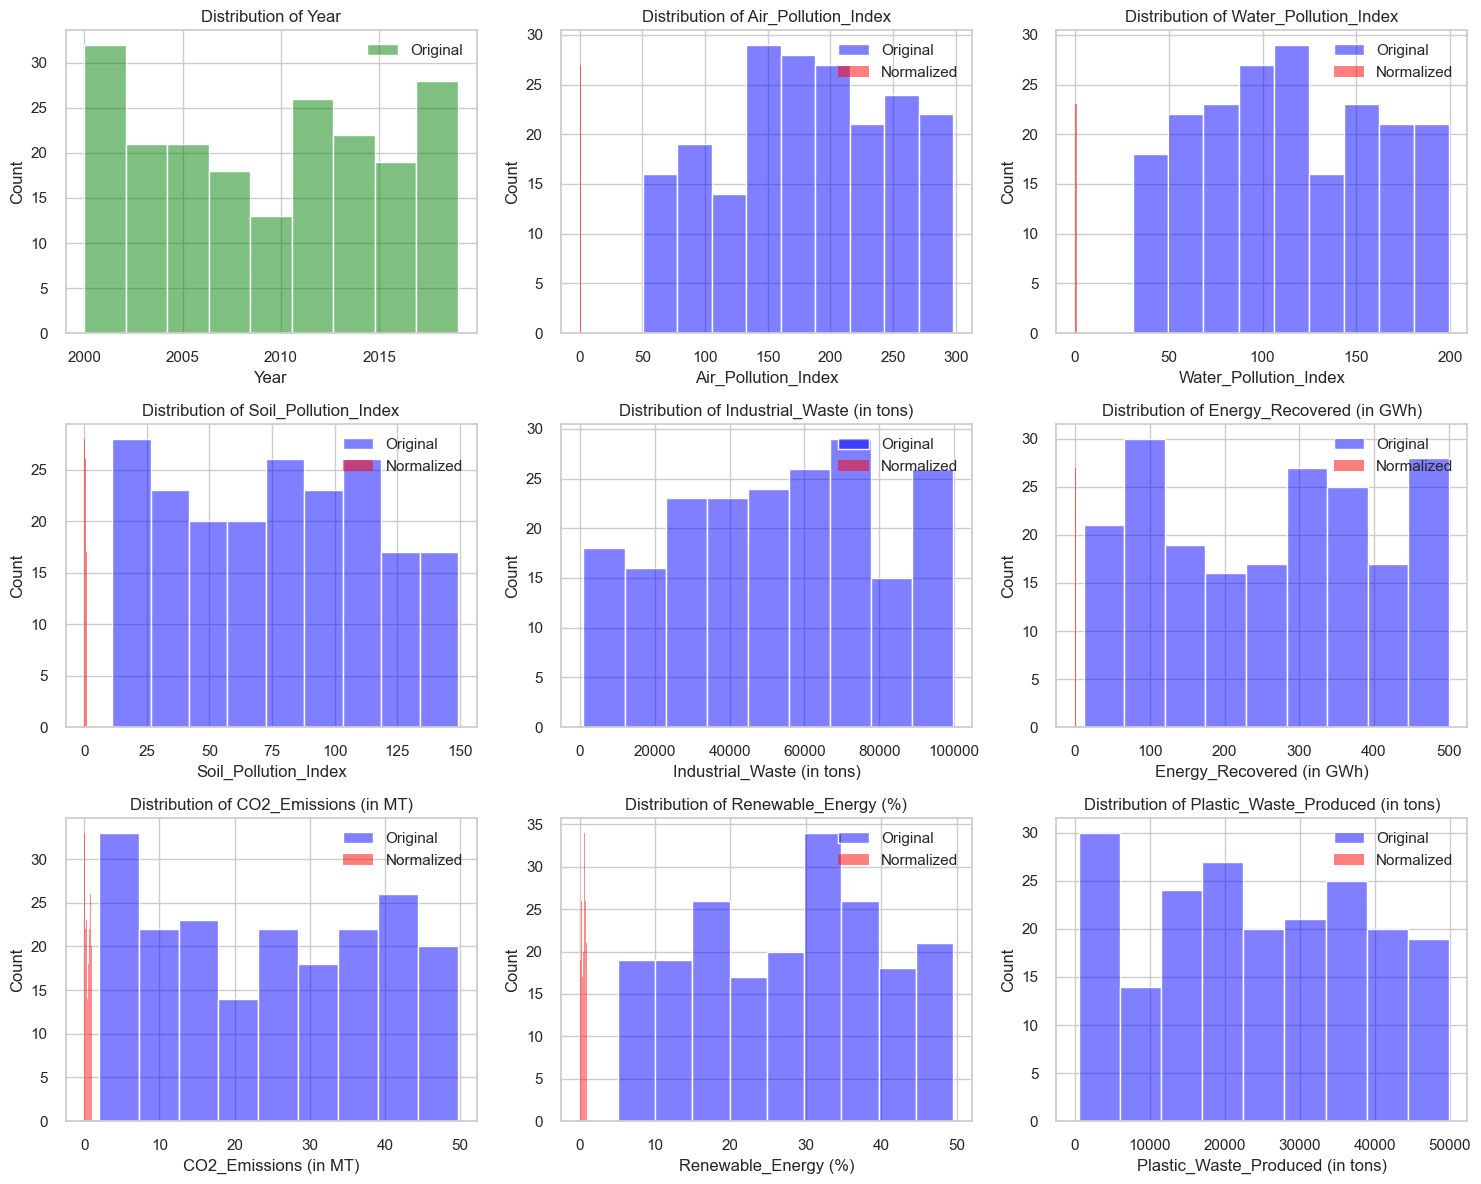

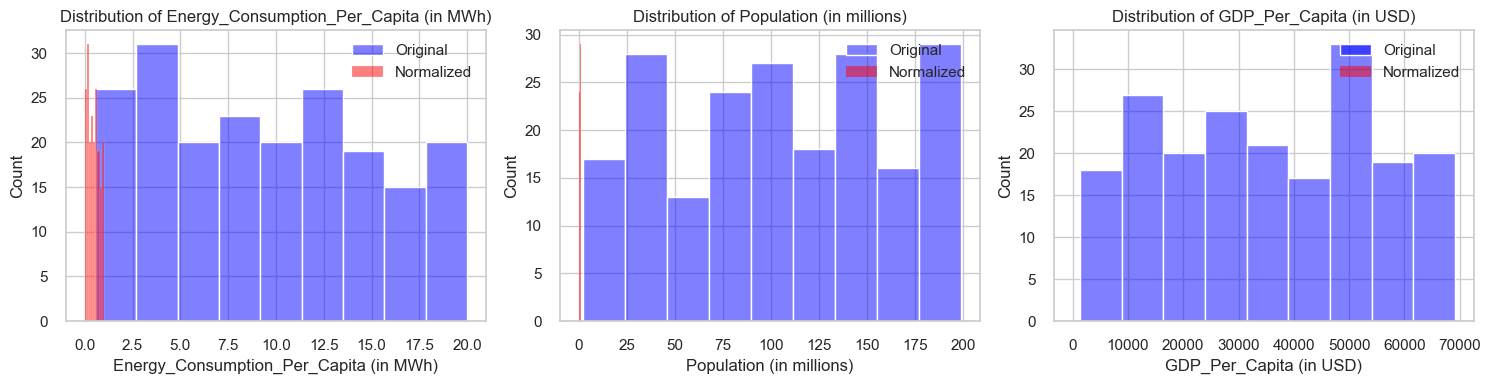

In [43]:
# Choose numeric columns
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Keep a copy of original numeric data
original_data = df[numeric_cols].copy()

# Normalize all except 'Year'
cols_to_normalize = [col for col in numeric_cols if col != 'Year']
scaler = MinMaxScaler()
normalized_values = scaler.fit_transform(original_data[cols_to_normalize])

# Build normalized DataFrame
normalized_data = original_data.copy()
normalized_data[cols_to_normalize] = normalized_values

# Plot in batches of 9 columns
cols_per_fig = 9
num_cols = len(numeric_cols)
num_figs = (num_cols - 1) // cols_per_fig + 1

for fig_num in range(num_figs):
    start_idx = fig_num * cols_per_fig
    end_idx = min(start_idx + cols_per_fig, num_cols)
    cols_in_fig = numeric_cols[start_idx:end_idx]
    
    n_subplots = len(cols_in_fig)
    n_rows = (n_subplots - 1) // 3 + 1
    n_cols = min(n_subplots, 3)
    
    plt.figure(figsize=(5 * n_cols, 4 * n_rows))
    
    for i, column in enumerate(cols_in_fig, 1):
        plt.subplot(n_rows, n_cols, i)
        if column != 'Year':
            sns.histplot(original_data[column], label='Original', alpha=0.5, color='blue')
            sns.histplot(normalized_data[column], label='Normalized', alpha=0.5, color='red')
        else:
            sns.histplot(original_data[column], label='Original', alpha=0.5, color='green')
        plt.title(f'Distribution of {column}')
        plt.legend()
    
    plt.tight_layout()
    plt.show()


Descriptive Statistics:
        Air_Pollution_Index  ...  GDP_Per_Capita (in USD)
count            200.00000  ...               200.000000
mean             180.62695  ...             35307.602400
std               67.07331  ...             19481.714455
min               50.30000  ...              1298.700000
25%              134.97250  ...             19525.020000
50%              183.38500  ...             35043.325000
75%              237.42500  ...             51629.547500
max              297.95000  ...             69143.140000

[8 rows x 11 columns]


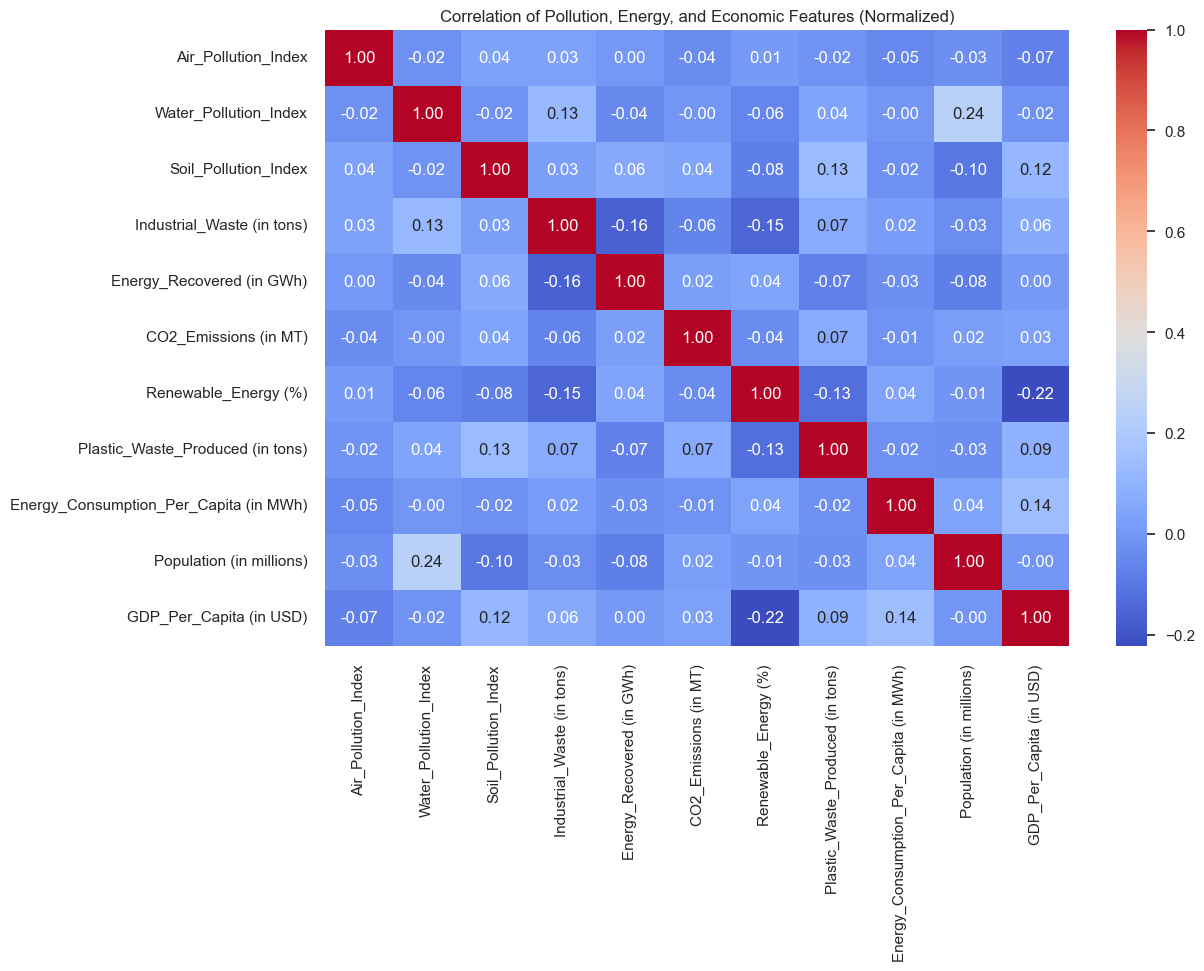

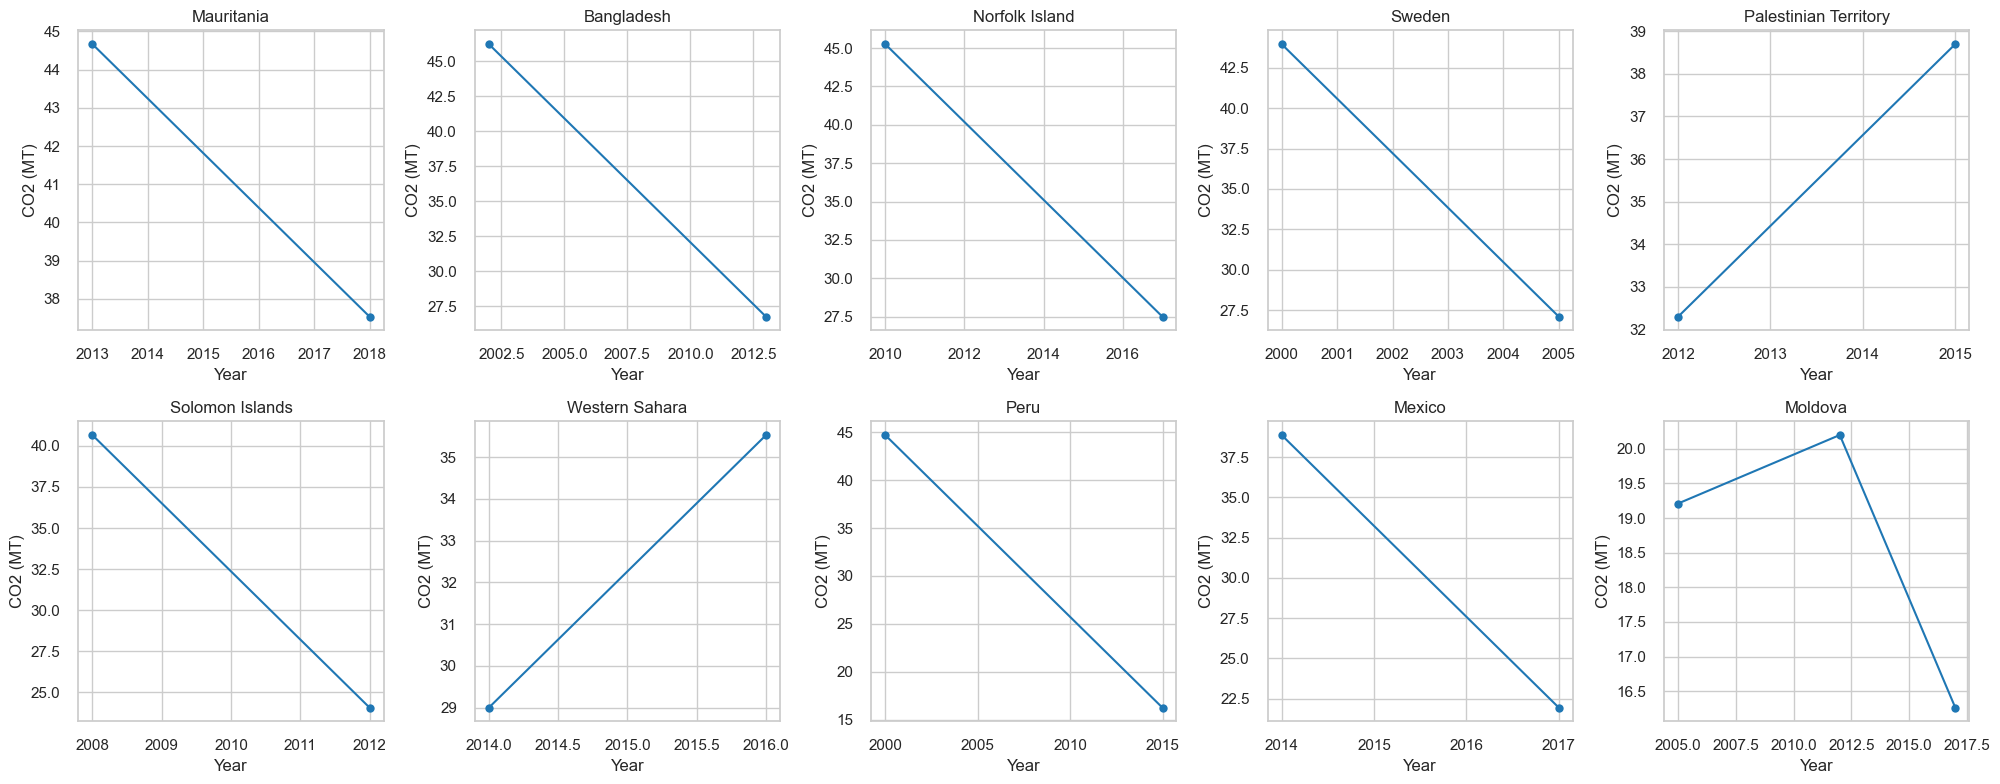

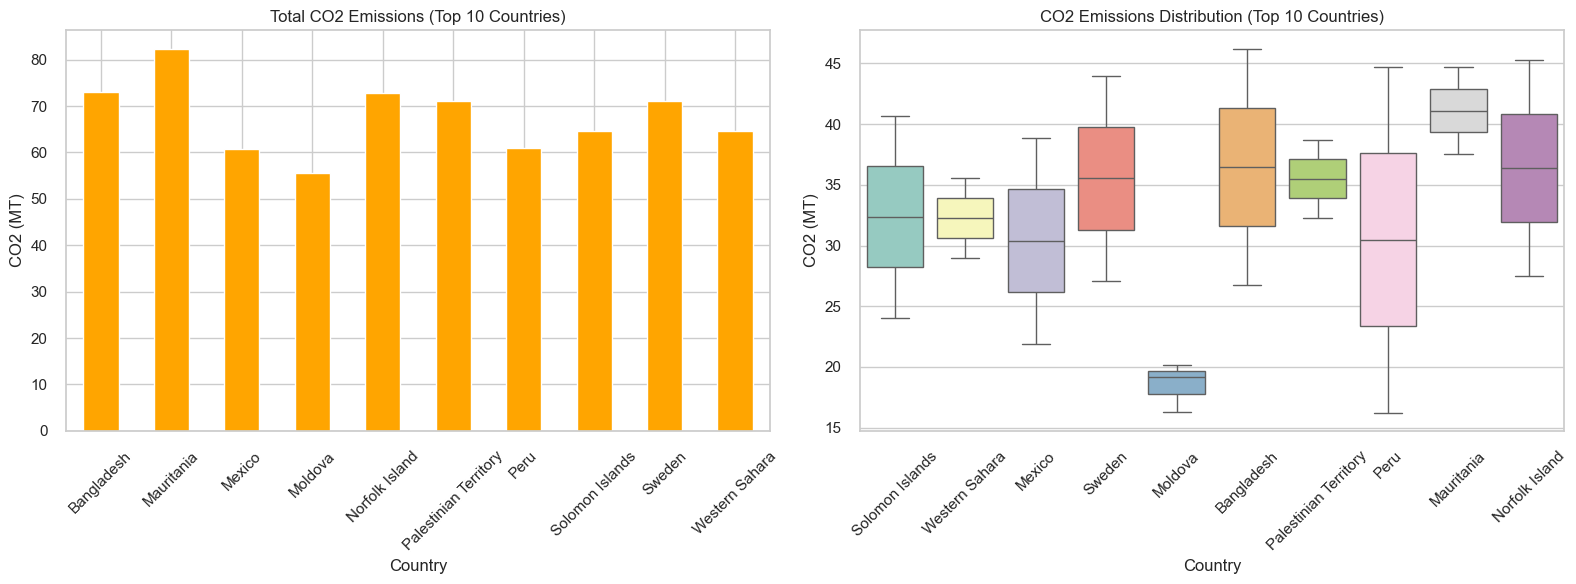

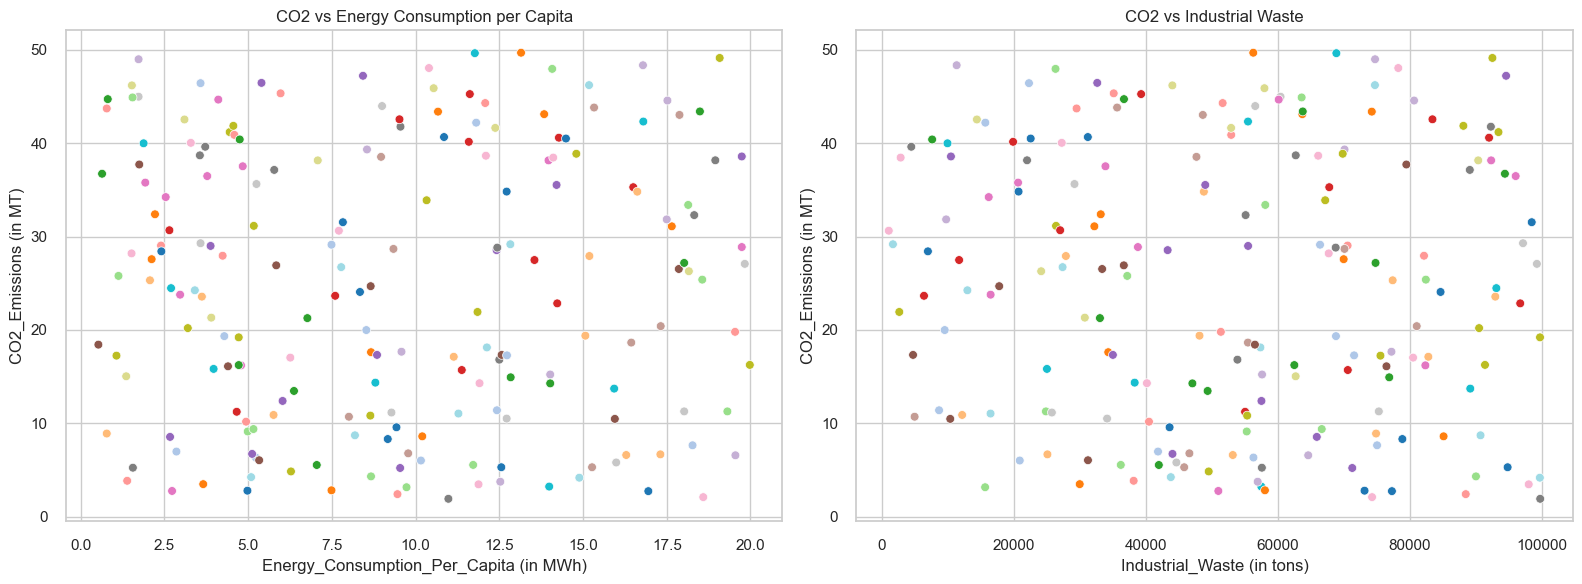

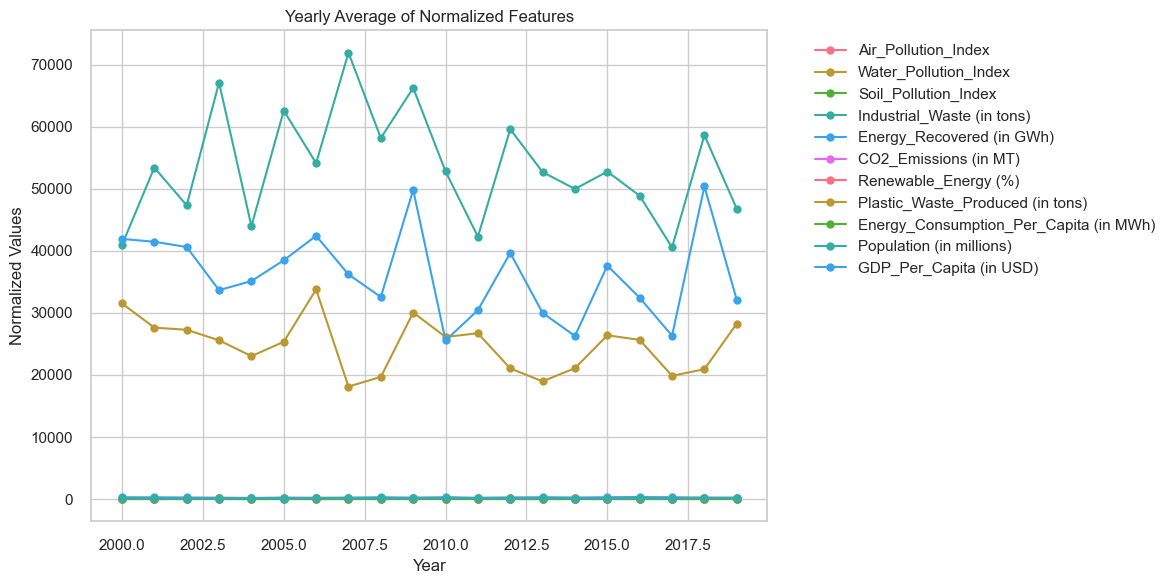

In [48]:

numeric_cols = [
    'Air_Pollution_Index', 'Water_Pollution_Index', 'Soil_Pollution_Index',
    'Industrial_Waste (in tons)', 'Energy_Recovered (in GWh)', 
    'CO2_Emissions (in MT)', 'Renewable_Energy (%)', 'Plastic_Waste_Produced (in tons)',
    'Energy_Consumption_Per_Capita (in MWh)', 'Population (in millions)', 
    'GDP_Per_Capita (in USD)'
]

# Descriptive Statistics
desc_stats = df[numeric_cols].describe()
print("Descriptive Statistics:\n", desc_stats)

# Normalize numeric features
scaler = MinMaxScaler()
df_normalized = df.copy()
df_normalized[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# Correlation Heatmap
plt.figure(figsize=(12,8))
sns.heatmap(df_normalized[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation of Pollution, Energy, and Economic Features (Normalized)')
plt.show()

# Top 10 Countries CO2 Trend (Subplots)
top_countries = df.groupby('Country')['CO2_Emissions (in MT)'].sum().sort_values(ascending=False).head(10)
selected_countries = top_countries.index.tolist()

fig, axes = plt.subplots(2, 5, figsize=(20,8)) 
axes = axes.flatten()

for i, country in enumerate(selected_countries):
    country_data = df[df['Country'] == country].groupby('Year')['CO2_Emissions (in MT)'].mean()
    axes[i].plot(country_data.index, country_data.values, marker='o', color='tab:blue')
    axes[i].set_title(f'{country}')
    axes[i].set_xlabel('Year')
    axes[i].set_ylabel('CO2 (MT)')
    axes[i].grid(True)

plt.tight_layout()
plt.show()

# Distribution Analysis: Top 10 Countries
fig, axes = plt.subplots(1,2, figsize=(16,6))

# Bar plot
df_top = df[df['Country'].isin(selected_countries)]
df_top.groupby('Country')['CO2_Emissions (in MT)'].sum().plot(
    kind='bar', ax=axes[0], color='orange'
)
axes[0].set_title('Total CO2 Emissions (Top 10 Countries)')
axes[0].set_ylabel('CO2 (MT)')
axes[0].set_xlabel('Country')
axes[0].tick_params(axis='x', rotation=45)

# Box plot
sns.boxplot(x='Country', y='CO2_Emissions (in MT)', data=df_top, ax=axes[1], palette='Set3')
axes[1].set_title('CO2 Emissions Distribution (Top 10 Countries)')
axes[1].set_xlabel('Country')
axes[1].set_ylabel('CO2 (MT)')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Scatter Plots (Smaller markers, no repeated legend)
fig, axes = plt.subplots(1,2, figsize=(16,6))

sns.scatterplot(
    x='Energy_Consumption_Per_Capita (in MWh)',
    y='CO2_Emissions (in MT)',
    data=df, hue='Country',
    palette='tab20', ax=axes[0], s=40, legend=False
)
axes[0].set_title('CO2 vs Energy Consumption per Capita')
axes[0].grid(True)

sns.scatterplot(
    x='Industrial_Waste (in tons)',
    y='CO2_Emissions (in MT)',
    data=df, hue='Country',
    palette='tab20', ax=axes[1], s=40, legend=False
)
axes[1].set_title('CO2 vs Industrial Waste')
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Yearly Average of Normalized Features
fig, ax = plt.subplots(figsize=(12,6))
for col in numeric_cols:
    yearly_avg = df.groupby('Year')[col].mean()
    ax.plot(yearly_avg.index, yearly_avg.values, marker='o', label=col)

ax.set_title('Yearly Average of Normalized Features')
ax.set_xlabel('Year')
ax.set_ylabel('Normalized Values')
ax.legend(bbox_to_anchor=(1.05,1), loc='upper left')
ax.grid(True)
plt.tight_layout()
plt.show()


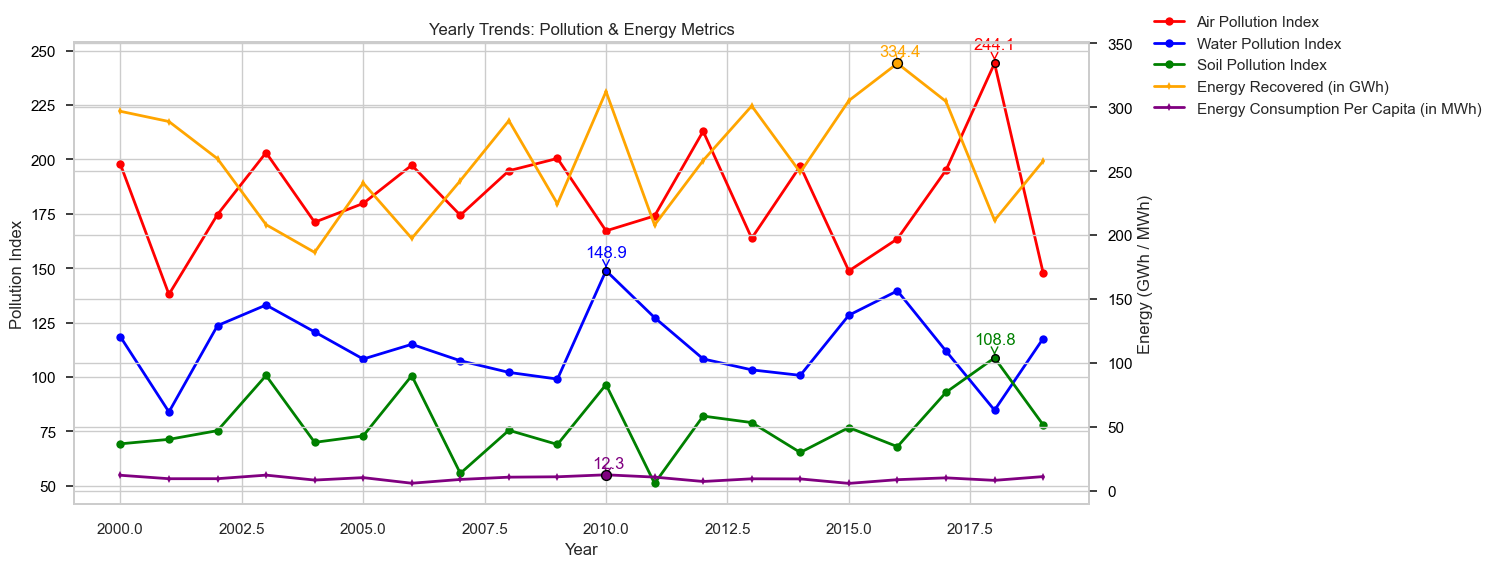

In [ ]:
# Step 1: Group by Year and calculate yearly averages
yearly_trends = df.groupby('Year').agg({
    'Air_Pollution_Index': 'mean',
    'Water_Pollution_Index': 'mean',
    'Soil_Pollution_Index': 'mean',
    'Energy_Recovered (in GWh)': 'mean',
    'Energy_Consumption_Per_Capita (in MWh)': 'mean'
}).reset_index()

# Step 2: Dual-axis plot with clean markers and annotations
fig, ax1 = plt.subplots(figsize=(14,6))

# Pollution indices (left y-axis)
pollution_colors = ['red','blue','green']
pollution_cols = ['Air_Pollution_Index','Water_Pollution_Index','Soil_Pollution_Index']

for col, color in zip(pollution_cols, pollution_colors):
    ax1.plot(yearly_trends['Year'], yearly_trends[col], marker='o', label=col.replace('_',' '), color=color, markersize=6, linewidth=2)

ax1.set_xlabel('Year')
ax1.set_ylabel('Pollution Index')
ax1.tick_params(axis='y', labelcolor='black')

# Highlight peak pollution years with small markers and arrows
for col, color in zip(pollution_cols, pollution_colors):
    peak_year = yearly_trends.loc[yearly_trends[col].idxmax(), 'Year']
    peak_value = yearly_trends[col].max()
    ax1.scatter(peak_year, peak_value, color=color, s=30, edgecolor='black', zorder=5)
    ax1.annotate(f'{peak_value:.1f}', xy=(peak_year, peak_value), xytext=(0,10),
                 textcoords='offset points', ha='center', color=color,
                 arrowprops=dict(arrowstyle='->', color=color, lw=1))

# Energy metrics (right y-axis)
energy_colors = ['orange','purple']
energy_cols = ['Energy_Recovered (in GWh)','Energy_Consumption_Per_Capita (in MWh)']
ax2 = ax1.twinx()

for col, color in zip(energy_cols, energy_colors):
    ax2.plot(yearly_trends['Year'], yearly_trends[col], marker='d', label=col.replace('_',' '), color=color, markersize=4, linewidth=2)

ax2.set_ylabel('Energy (GWh / MWh)')
ax2.tick_params(axis='y', labelcolor='black')

# Highlight peak energy metrics with small markers and arrows
for col, color in zip(energy_cols, energy_colors):
    peak_year = yearly_trends.loc[yearly_trends[col].idxmax(), 'Year']
    peak_value = yearly_trends[col].max()
    ax2.scatter(peak_year, peak_value, color=color, s=50, edgecolor='black', zorder=5)
    ax2.annotate(f'{peak_value:.1f}', xy=(peak_year, peak_value), xytext=(2,5),
                 textcoords='offset points', ha='center', color=color,
                 arrowprops=dict(arrowstyle='->', color=color, lw=1))

# Combine legends outside
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='center left', bbox_to_anchor=(1.05, 0.95))

plt.title('Yearly Trends: Pollution & Energy Metrics')
plt.grid(True)
plt.subplots_adjust(right=0.85)
plt.show()


In [2]:
features = [
    'Air_Pollution_Index',
    'Water_Pollution_Index',
    'Soil_Pollution_Index',
    'CO2_Emissions (in MT)',
    'Industrial_Waste (in tons)'
]

X = df[features]
y = df['Energy_Recovered (in GWh)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("Model Performance:")
print(f"R² Score      : {r2:.4f}")
print(f"MSE           : {mse:.4f}")
print(f"RMSE          : {rmse:.4f}")
print(f"MAE           : {mae:.4f}")

coefficients = pd.DataFrame({
    'Feature': features,
    'Coefficient': model.coef_
})
print("\nFeature Importance (Linear Coefficients):")
print(coefficients)

# Scatter Plot: Actual vs Predicted
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6, edgecolors='k', s=60, label="Predictions")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label="Ideal Fit (y=x)")

plt.xlabel("Actual Energy Recovered (in GWh)")
plt.ylabel("Predicted Energy Recovered (in GWh)")
plt.title("Actual vs Predicted: Linear Regression Model")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



NameError: name 'df' is not defined

Accuracy: 0.975
Precision: 0.9756410256410255
Recall: 0.975
F1-score: 0.9709956709956711

Classification Report:
               precision    recall  f1-score   support

         Low       0.00      0.00      0.00         0
      Medium       1.00      0.50      0.67         2
        High       0.97      1.00      0.99        38

    accuracy                           0.97        40
   macro avg       0.66      0.50      0.55        40
weighted avg       0.98      0.97      0.97        40



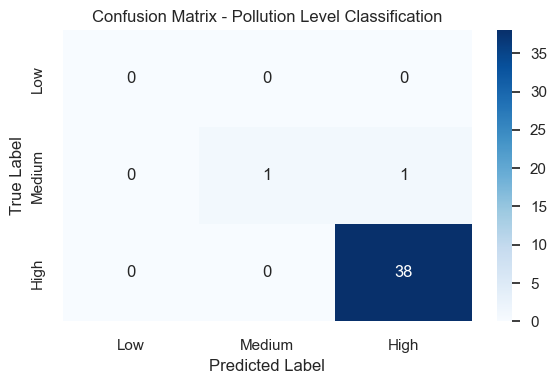

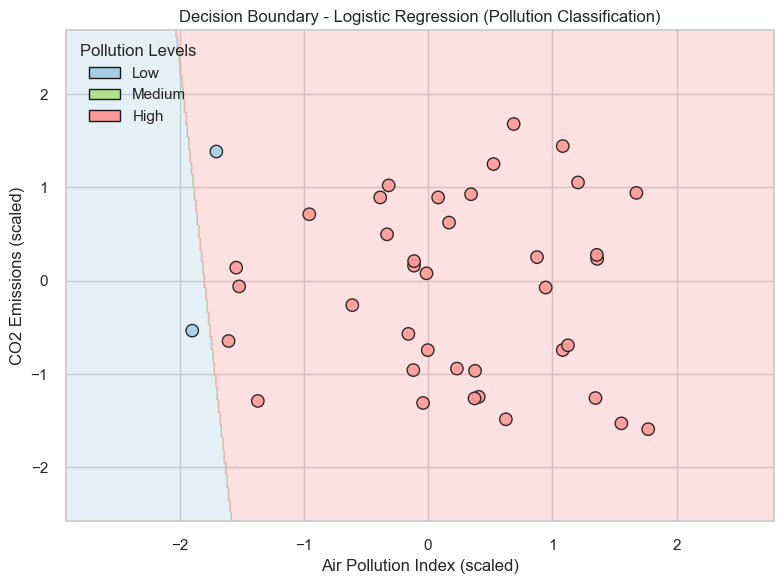

In [90]:
# =============================
# Step 5 - Logistic Regression Model (Pollution Categorization)
# =============================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap

# -----------------------------
# Step 1: Create Pollution Category
# -----------------------------
def categorize_pollution(value):
    if value < 35:
        return "Low"
    elif 35 <= value < 70:
        return "Medium"
    else:
        return "High"

df["Pollution_Level"] = df["Air_Pollution_Index"].apply(categorize_pollution)

# Encode target
df["Pollution_Level_Code"] = df["Pollution_Level"].map({"Low": 0, "Medium": 1, "High": 2})

# -----------------------------
# Step 2: Features & Target
# -----------------------------
X = df[["Air_Pollution_Index", "CO2_Emissions (in MT)"]]
y = df["Pollution_Level_Code"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# -----------------------------
# Step 3: Scaling
# -----------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# -----------------------------
# Step 4: Train Logistic Regression
# -----------------------------
log_reg = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=1000, random_state=42)
log_reg.fit(X_train_scaled, y_train)

# Predictions
y_pred = log_reg.predict(X_test_scaled)

# -----------------------------
# Step 5: Evaluation Metrics
# -----------------------------
labels_list = [0, 1, 2]
label_names = ["Low", "Medium", "High"]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average="weighted", zero_division=0))
print("Recall:", recall_score(y_test, y_pred, average="weighted", zero_division=0))
print("F1-score:", f1_score(y_test, y_pred, average="weighted", zero_division=0))

print("\nClassification Report:\n", classification_report(
    y_test, y_pred, labels=labels_list, target_names=label_names, zero_division=0
))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=labels_list)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_names, yticklabels=label_names)
plt.title("Confusion Matrix - Pollution Level Classification")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# -----------------------------
# Step 6: Decision Boundary
# -----------------------------
cmap = ListedColormap(['#a6cee3', '#b2df8a', '#fb9a99'])

x_min, x_max = X_train_scaled[:, 0].min() - 1, X_train_scaled[:, 0].max() + 1
y_min, y_max = X_train_scaled[:, 1].min() - 1, X_train_scaled[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500))

Z = log_reg.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap)

plt.scatter(X_test_scaled[:, 0], X_test_scaled[:, 1],
            c=y_test, cmap=cmap, edgecolor='k', s=80, alpha=0.9)

handles = [Patch(facecolor=cmap.colors[i], edgecolor='k', label=label_names[i]) for i in range(3)]
plt.legend(handles=handles, title="Pollution Levels", loc="upper left")

plt.xlabel("Air Pollution Index (scaled)")
plt.ylabel("CO2 Emissions (scaled)")
plt.title("Decision Boundary - Logistic Regression (Pollution Classification)")
plt.tight_layout()
plt.show()


In [3]:
# =============================
# Step 6 - Compare Linear vs Logistic Regression
# =============================

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# -----------------------------
# 1. Linear Regression Performance (Regression Task)
# -----------------------------
print("=== Linear Regression (Predict Energy_Recovered) ===")
print("R² Score:", r2_score(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolors="k", s=80, color="blue", label="Predictions")
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         "r--", lw=2, label="Perfect Fit")
plt.xlabel("Actual Energy Recovered (GWh)")
plt.ylabel("Predicted Energy Recovered (GWh)")
plt.title("Linear Regression: Actual vs Predicted")
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------
# 2. Logistic Regression Performance (Classification Task)
# -----------------------------
print("\n=== Logistic Regression (Classify Pollution Level) ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average="weighted", zero_division=0))
print("Recall:", recall_score(y_test, y_pred, average="weighted", zero_division=0))
print("F1-score:", f1_score(y_test, y_pred, average="weighted", zero_division=0))

print("\nClassification Report:\n", classification_report(
    y_test, y_pred, labels=[0,1,2], target_names=["Low", "Medium", "High"], zero_division=0
))

cm = confusion_matrix(y_test, y_pred, labels=[0,1,2])
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Low", "Medium", "High"],
            yticklabels=["Low", "Medium", "High"])
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


=== Linear Regression (Predict Energy_Recovered) ===


NameError: name 'y_test' is not defined